# Lesson Analysis

In this notebook I will be going thorugh the proposal of a new lesson metric which aims to work similarly to ever in hand, but for lessons. To do this we will:

1. Examine that the likelyhood of any lesson being drawn
2. Show that the likelihood of any lesson being drawn is proportional to the amount of learn cards in the deck
1. Estimate the winrate of lessons given the amount of learn cards in the deck
1. Show that the winrate of lessons with learn in hand is comparable to winrate of decks with lessons in their sideboard.

## Measuring the Winrate of Situationally Good Cards
The average winrate of a situational cards that start in your deck is currently best captured by "Ever In Hand Winrate" winrate metric. "Ever In Hand Winrate" is used over the "Winrate When Cast" because winrate when cast selects highly for cards that are situationally good like [Warhorn Blast](https://scryfall.com/card/khm/38/warhorn-blast) from KHM limited. [Warhorn Blast](https://scryfall.com/card/khm/38/warhorn-blast) is situationally good when you have a large board presenece/are the agressor. Players are more likely to cast it in games where you have lethal after casting it then in games where you are at parity or behind. To account for this "Ever In Hand" takes into account that situationally good cards should be measured when you have access to their effects and not when you cast the spell. "Ever In Hand" does this by only taking into account the winrate of cards that you have the opportunity to cast, not whether they were cast. This is important because it is our best guess at how good a card is on average. "Ever In Hanhd" estimates the average winrate of a card by taking the winrates of games where situationally good cards are good and averaging them into games where the card is either not as good, or perhaps even has no targets. The weighting of these scenarios is naturally the probability that they occur by virtue of looking at all the games where a player had access to the effect because the situations where a card is good will naturally occur at the rate they they are probable to happen.

## Proposed Replacement for Lessons being drawn 
Currently only looking at "Ever In Hand" has a similar effect to "Winrate When Cast" because it biased towards situationally good cards. For lessons "Ever In Hand" is biased towards situationally good lessons because on average lessons will be fetched when they are good. When a lesson is not good a caster has the option to draw a random card over a lesson. To remedy this, we need a winrate which takes into account the situations where a lesson is good. To do this, I am proposing that we look at the winrate of lessons when a learn card is drawn. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Get hypergeometric coefficients
import scipy.stats as ss

In [2]:
'''
Utility functions

Functions that are used throughout the notebook are put here to try to reduce clutter in later analysis
'''
# Game data from https://www.17lands.com/public_datasets
game_data_filename = 'game_data_public.STX.Sealed.csv'
# STX Lessons retreived with the scryfall API
stx_lessons = pd.read_csv("stx_lesson.csv")
# STX Cards with learn retreived with the scryfall API
stx_learn = pd.read_csv("stx_learn.csv")


#####################################################################################################
# Get list of card names
#
# \param[in] df     The data you are getting the card names from
# \param[in] prefix An optional prefix to prepend to the card names 
#
# \return A list of card names
def get_card_name_list(df, prefix=""):
    cards = [prefix+col.replace("deck_","") for col in df.columns if 'deck' in col]
    return cards

#####################################################################################################
# Add columns to track the winrate of each card
#
# \param[in] df The data to add a column to
#
# \return The data with columns added to track the winrate of each card
def add_col_winrate_when_in_hand(df):
    # Generate list for new column names
    in_hand = get_card_name_list(df,"in_hand_")
    # Add the cards that are either drawn or in opening hand
    df[in_hand] = \
        df[get_card_name_list(df,"drawn_")].to_numpy() \
        + df[get_card_name_list(df,"opening_hand_")].to_numpy()
    # Flatten the data to only detect if the card was drawn and not care about quantity
    df[in_hand] = df[in_hand] > 0
    # Convert to Int
    df[in_hand] = df[in_hand].to_numpy(dtype=int)
    # Store win/loss for each game
    # Storing the data in an additional column helps when we aggregate the data in a later step by
    # accumulating it in a column as opposed to a local variable
    ihw = get_card_name_list(df,"ihw_")
    df[ihw] = df[in_hand].mul(df["won"],axis=0)
    return df

#####################################################################################################
# This function returns an iterator with a batch of data. Batching makes intermittent steps easier to
# examine for correctness and also allows for a "loading bar" to post incremental progress
#
# \param[in] chunksize - Size of the chunk of data to process. Optional with default 2000
#
# \return dataiter - an iterator that returns data frames containing batches of cards 
def get_data_iter(chunksize = 2000):
    data_iter = pd.read_csv(game_data_filename,chunksize=chunksize)
    data = next(data_iter)
    data.columns = [column.lower() for column in data.columns]
    # Filter by columns that we are performing calculations on
    filtered_columns = sum([ \
                    get_card_name_list(data,"deck_"),
                    get_card_name_list(data,"opening_hand_"),
                    get_card_name_list(data,"drawn_"),
                    get_card_name_list(data,"sideboard_"),
                    ["won","num_turns"]
                   ], [])
    data = data[filtered_columns]
    data = add_col_winrate_when_in_hand(data)
    yield data
    for data in data_iter:
        data.columns = [column.lower() for column in data.columns]
        data = data[filtered_columns]
        data = add_col_winrate_when_in_hand(data)
        yield data

#####################################################################################################
# Get table for expected probability for the game to end on turn N with a card in hand, given that
# you have M copies of the card in your deck
# 
# Acessing the table:
# Note: turns_df has to have a column named num_games which has the relative frequency of games that
# end on turn N
# ---------------------------------
# expected_drawn = get_expected_drawn_table(turns_df) 
# expected_drawn[M][N]
# M - Number of copies in deck
# N - Number of turns when the game ended
#
# \param[in] turns_df      The turn data with an expected column "num_games" which has the
#                          distrubtion of games which ended on turn N
# \param[in] cards_in_deck The number of cards in a deck. Default 40.
# \param[in] starting_hand The number of cards in your starting hand. Default 7.
#
# \return An expected probability table with columns labeled with the number of copies of a card in
#         the deck and the rows labeled with the number of turns
def get_expected_drawn_table(turns_df, cards_in_deck=40, starting_hand=7):
    # Game ends when you draw your deck on average
    max_turns = cards_in_deck - starting_hand
    # Game ends when you 
    max_copies = cards_in_deck
    turn_dist = pd.DataFrame(np.zeros(max_turns), index=range(1,max_turns+1), columns=["turn_dist"])
    turn_dist["turn_dist"] = turn_dist["turn_dist"].add(turns_df["num_games"], fill_value=0)
    turn_dist = turn_dist["turn_dist"]/sum(turn_dist["turn_dist"])
    expected_drawn = pd.DataFrame()
    # Set to zero to zero to compensate for floating point error with calculations
    expected_drawn[0] = turn_dist*np.zeros(max_turns)
    # Coefficients of the hypergeometric distribution
    # Hypergeometric distribution is the likelyhood you draw
    # N copies of a card with M chances
    # Iterate over copies and turns
    for copies in range(1, max_copies+1):
        expected_drawn_N_copies = []
        for turns in range(1,max_turns+1):
            # We are assuming that on average cards drawn on turn M is M + starting_hand
            cards_drawn = turns + starting_hand
            hgd = ss.hypergeom(cards_in_deck,  copies, cards_drawn)
            # The probability of drawing any copies is one minus the probability of drawing zero
            expected_drawn_N_copies.append(1-hgd.pmf(0))
        expected_drawn_N_copies = turn_dist*expected_drawn_N_copies
        expected_drawn_N_copies = expected_drawn_N_copies/sum(expected_drawn_N_copies)
        expected_drawn[copies] = expected_drawn_N_copies
    return expected_drawn

In [3]:
'''
Raw Calculations

Calculate the likelyhood of drawing a card with learn. 
Calculate the likelyhoood of drawing a lesson.
'''
# Group the data by number of turns
# Add a num_games column to track the number of games that took a particular length
def group_num_turns(df):
    df["num_games"] = 1
    df = df.groupby(by="num_turns").sum()
    return df

data_iter = get_data_iter()
data_grouped_by_turn_count = next(data_iter)
data_grouped_by_turn_count = group_num_turns(data_grouped_by_turn_count)
# Used to track progress
counter = 0
for batch in data_iter:
    print(counter,end=" ")
    batch = group_num_turns(batch)
    data_grouped_by_turn_count = data_grouped_by_turn_count.add(batch,fill_value=0)
    counter += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

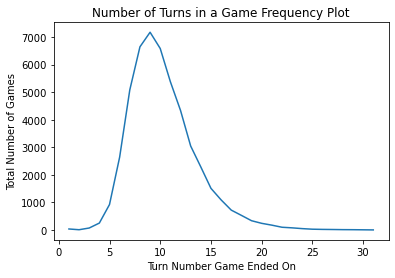

In [4]:
plt.plot(data_grouped_by_turn_count["num_games"])
plt.xlabel('Turn Number Game Ended On')
plt.ylabel('Total Number of Games')
plt.title("Number of Turns in a Game Frequency Plot")
plt.show()

# Showing The Likelyhood of drawing a lesson
We theorize that the likelyhood of drawing a lesson is similar to the likelyhood of drawing any card with learn because you use learn cards to search for a lesson. To show this we are going to plot the sampled likelyhood of drawing a lesson for games that end on turn N with the sampled lieklyhood that you drew a learn card for games that ended on turn N.

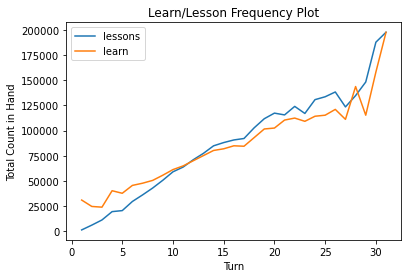

In [5]:
# Expected Turn Frequency of data
turn_freq = data_grouped_by_turn_count["num_games"]
turn_freq = turn_freq/(turn_freq.sum())

# plot draw rates of lessons
lessons = data_grouped_by_turn_count["in_hand_"+stx_lessons["name"]]
lessons = lessons.sum(axis=1)
lessons = lessons/turn_freq # Scale based on frequency of games ending on turn N
lessons_plot = plt.plot(lessons, label='lessons')

# plot draw rates of learn cards
learn = data_grouped_by_turn_count["in_hand_"+stx_learn["name"]]
learn = learn.sum(axis=1)
learn = learn/turn_freq #Scale based on frequency of games ending on turn N
learn_plot = plt.plot(learn, label='learn')

plt.xlabel('Turn')
plt.ylabel('Total Count in Hand')
plt.title("Learn/Lesson Frequency Plot")
plt.legend()
plt.show()

# Compare "Learn Drawn "to "Lessons Drawn"
Now that we have the rate at which lessons and learn occur in games, we will plot the error of the estimate below. What we can see is that "learn drawn" slightly over represents "lessons drawn" in the early game, but as the number of turns increases the error gets smaller. This is because learn cards draw a lesson when they are cast. The underestimation of lessons by learn in the late game is probably due to lessons in deck or recursion in the format, but is <0.2% difference by inspection with the caviat that there is less data from games >20 turns so the variance is wider.

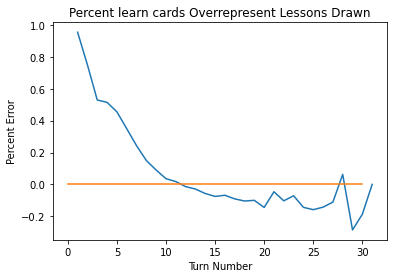

num_turns
1     0.954545
2     0.750000
3     0.529412
4     0.514706
5     0.455319
6     0.349733
7     0.243183
8     0.149787
9     0.089831
10    0.035977
11    0.017675
12   -0.013975
13   -0.029329
14   -0.057320
15   -0.075479
16   -0.068267
17   -0.090983
18   -0.104418
19   -0.100145
20   -0.144578
21   -0.046272
22   -0.103139
23   -0.071429
24   -0.144144
25   -0.158730
26   -0.142857
27   -0.111111
28    0.062500
29   -0.285714
30   -0.187500
31    0.000000
dtype: float64

In [6]:
# Plot difference
compare = (learn-lessons)/(learn)
plt.plot(compare)
plt.plot(np.zeros(len(compare)))

plt.xlabel('Turn Number')
plt.ylabel('Percent Error')
plt.title("Percent learn cards Overrepresent Lessons Drawn")
plt.show()
compare

# Estimate the winrate of lessons
In this section we will estimate the winrate of each lesson by looking at the winrate of decks with the lesson in the sideboard which drew a card with learn.

In [7]:
# Table of expected rate of drawing a card given you have n copies of the card and it's turn n
expected_drawn = get_expected_drawn_table(data_grouped_by_turn_count)

In [8]:
'''
Raw Calculations

Calculate the likelyhood of winning with a card in sideboard
Calculate the likelyhoood of winning with a card in sideboard, weighting it based on the number of learn cards in deck
'''
def add_lessons_columns(df): 
    # Add column for winrate given the lesson was in the sb
    df["lesson_sb_"+stx_lessons["name"]] = (df["sideboard_" + stx_lessons["name"]]>0).to_numpy(dtype=int)
    df["lesson_sb_won_"+stx_lessons["name"]] = df["lesson_sb_"+stx_lessons["name"]].mul(df["won"],axis=0)
    # Add columns for winrate given the lesson was in the sideboard and you drew the card with learn
    learn= df["in_hand_"+stx_learn["name"]]
    df["learn_drawn"] = learn.sum(axis=1)
    # Weight each sample based on the likelyhood that the game ended on turn N given that you had "learn_drawn"
    # number of learn cards using hypergeomteric distribution and the sampled turn length data
    df["learn_weight"] = [expected_drawn[x][y] for x,y in zip(df["learn_drawn"],df["num_turns"])]
    df["lessons_weighted_" + stx_lessons["name"]] =  df["lesson_sb_"+stx_lessons["name"]].mul(df["learn_weight"],axis=0)
    df["lessons_weighted_won_" + stx_lessons["name"]] = df["lessons_weighted_" + stx_lessons["name"]].mul(df["won"],axis=0)
    return df


data_iter = get_data_iter()
lesson_winrate = next(data_iter)
lesson_winrate = add_lessons_columns(lesson_winrate)
lesson_winrate = lesson_winrate.sum()
counter = 0
for batch in data_iter:
    print(counter,end=" ")
    batch = add_lessons_columns(batch)
    batch = batch.sum()
    lesson_winrate = lesson_winrate.add(batch, fill_value=0)
    counter += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

# Correlation of "Lesson in Sideboard" to "Ever Drawn Learn Card" for Lessons
Here we show that the winrate of lessons in the sideboard is correlated to the winrate of decks with the same lesson cards in the sideboard. This is a strong indication that our proposed metric is correct since sb is unbiased towards cards that are situationally good.

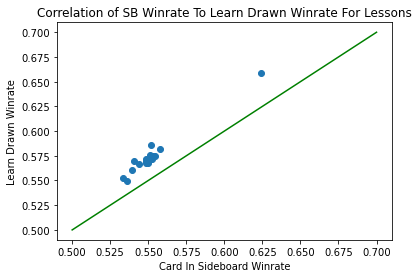

In [9]:
first_cn = "environmental sciences"
last_cn = "basic conjuration"

# Calculate the winrate of cards of decks with lesson cards in the sideboard
sb_played = lesson_winrate.loc["lesson_sb_"+first_cn:"lesson_sb_"+last_cn].to_numpy()
sb_won = lesson_winrate.loc["lesson_sb_won_"+first_cn:"lesson_sb_won_"+last_cn].to_numpy()
sb_winrate = sb_won/(sb_played + 0.0000001) # DEBUG: Divide by Zero Error

# Calculate the winrate of games where a learn card was drawn and there was a lesson in the sb
weighted_played = lesson_winrate.loc["lessons_weighted_"+first_cn:"lessons_weighted_"+last_cn].to_numpy()
weighted_won = lesson_winrate.loc["lessons_weighted_won_"+first_cn:"lessons_weighted_won_"+last_cn].to_numpy()
weighted_winrate = weighted_won/(weighted_played + 0.0000001) # DEBUG: Divide by Zero Error

plt.scatter(sb_winrate, weighted_winrate)
# Y=X For reference
plt.plot(np.linspace(0.5,0.7,200),np.linspace(0.5,0.7,200), color='green' )
plt.xlabel('Card In Sideboard Winrate')
plt.ylabel('Learn Drawn Winrate')
plt.title("Correlation of SB Winrate To Learn Drawn Winrate For Lessons")
plt.show()

In [10]:
# Show the data in a table
a = np.array([sb_winrate.T, weighted_winrate])
winrates = pd.DataFrame( 
                        data=a.T,
                        columns=["sb_winrate", "weighted_winrate"],
                        index=stx_lessons["name"])
winrates.sort_values("weighted_winrate",ascending=False)
winrates


,sb_winrate,weighted_winrate
name,,
environmental sciences,0.557820,0.581813
expanded anatomy,0.551147,0.575871
containment breach,0.533482,0.552922
mercurial transformation,0.548585,0.571275
confront the past,0.540735,0.570010
spirit summoning,0.552007,0.573550
elemental summoning,0.549649,0.567913
reduce to memory,0.548583,0.567830
pest summoning,0.552110,0.573144
